\begin{align}
    u &= \sin{(2t\pi)} \\
\dot{u} &= 2\pi\cos{(2t\pi)}
\end{align}

In [149]:
from PIL import Image
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pickle
import scipy.signal as sig
import numpy as np

In [150]:
# from matlab script############################################################
#cPS = 1e6 * 4 # Stiffness Primary Suspension
#dPS = 1e4 * 4 # Damping Primary Suspension
#mDG = 3000
cSS = 0.5e6 * 2 # Stiffness Secondary Suspension
dSS = 1.5e4 * 2 # Stiffness Primary Suspension
m = 30000/2

cSF = cSS;
dSF = dSS

c = (cSF/m)
d = (dSF/m)

t_orig = np.linspace(0, 2*np.pi, 502)

u_raw = np.sin(t_orig)
#u_raw = np.zeros_like(z_raw)uncomment for ben mosley test case
up_raw = np.cos(t_orig)# np.diff(np.squeeze(u_raw))/np.diff(np.squeeze(tExci))
#u_raw = np.zeros_like(u_raw)uncomment for ben mosley test case

u_orig = np.expand_dims(u_raw,1)
up_orig = np.expand_dims(up_raw,1)
t_orig =  np.expand_dims(t_orig, 1)

# Simulate solution 

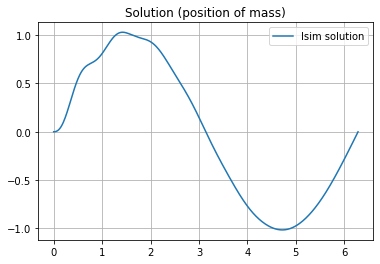

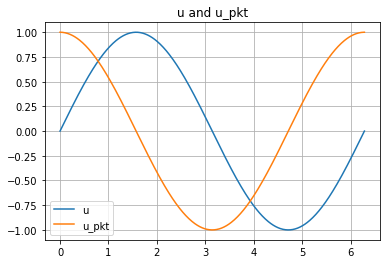

In [151]:
A =  np.array([
    [0, 1],
    [-cSF/m, -dSF/m]])

B =  np.array(
  [[0, 0],
    [cSF/m, dSF/m]])


C = np.array([[1, 0]]) # extract x1 = position
D = np.zeros((1, 2))

OneMassOsci = sig.StateSpace(A,B,C,D)

sys_input = np.hstack((u_orig, up_orig))

tsim_nom_orig,x_true,tsim_nom_orig = sig.lsim(OneMassOsci,sys_input,np.squeeze(t_orig),X0=[0,0])
#tsim_nom_orig,y_orig,xsim_nom_orig = sig.lsim(OneMassOsci,sys_input,np.squeeze(tExci),X0=[1,0]) use for ben mosley testcase
x_true = np.expand_dims(x_true, 1)

t = torch.tensor(t_orig[:500]).float()
x = torch.tensor(x_true[:500]).float()
u = torch.tensor(u_orig[:500]).float()
u_pkt = torch.tensor(up_orig[:500]).float()

plt.figure()
plt.title("Solution (position of mass)")
plt.plot(t_orig, x_true, label="lsim solution")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.title("u and u_pkt")
plt.plot(t_orig, u_orig, label="u")
plt.plot(t_orig, up_orig, label="u_pkt")
plt.grid()
plt.legend()
plt.show()

#Calculate solution by hand
Physiscs loss term is given by: 
\begin{align}
    0 &= -\ddot{x}-d\dot{x}-cx+d\dot{u}+cu
\end{align}
where c is $\frac{ \textrm{cSF}}{m}$ and d is $\frac{ \textrm{dSF}}{m}$ \\
we need to calculate $\ddot{x}$ and $\dot{x}$:

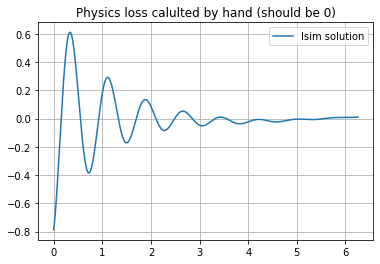

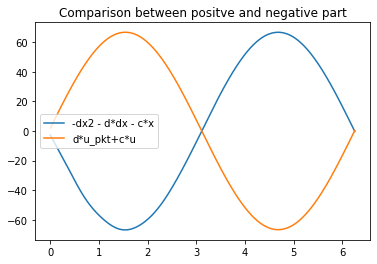

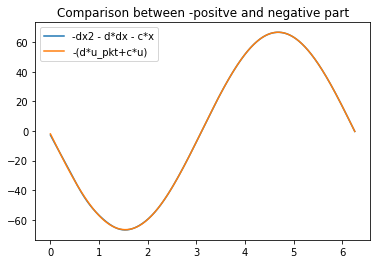

Peak/Valley positions should be the same
Peak positions negative part/ positive part: [373] / [373]
Valley positions negative part/ positive part: [122] / [123]


In [152]:
# solution by hand 
dx_hand = np.diff(np.squeeze(x_true))/np.diff(np.squeeze(t_orig))
dx2_hand = np.diff(dx_hand)/np.diff(np.squeeze(t_orig[:(t_orig.shape[0]-1)])) # we lose one sample because of diff function

new_len = (t_orig.shape[0]-2)
res_hand = -dx2_hand - d*dx_hand[:new_len] - c*x_true[:new_len,0] + d*up_orig[:new_len,0] + c*u_orig[:new_len,0]
plt.figure()
plt.title("Physics loss calulted by hand (should be 0)")
plt.plot(t[:new_len], res_hand, label="lsim solution")
plt.grid()
plt.legend()
plt.show()

negative = -dx2_hand - d*dx_hand[:new_len] - c*x_true[:new_len,0]
positive = d*up_orig[:new_len,0] + c*u_orig[:new_len,0]

plt.figure()
plt.plot(t[:new_len], negative, label="-dx2 - d*dx - c*x")
plt.plot(t[:new_len], positive, label="d*u_pkt+c*u")
plt.title("Comparison between positve and negative part")
plt.legend()
plt.show()

plt.figure()
plt.plot(t[:new_len], negative, label="-dx2 - d*dx - c*x")
plt.plot(t[:new_len], -positive, label="-(d*u_pkt+c*u)")
plt.title("Comparison between -positve and negative part")
plt.legend()
plt.show()

from scipy.signal import find_peaks
peaks_n, _ = find_peaks(negative)
peaks_p, _ = find_peaks(-positive)
val_n, _ = find_peaks(-negative)
val_p, _ = find_peaks(positive)
print("Peak/Valley positions should be the same")
print("Peak positions negative part/ positive part: {peaks_n} / {peaks_p}".format(peaks_n=peaks_n, peaks_p=peaks_p))
print("Valley positions negative part/ positive part: {val_n} / {val_p}".format(val_n=val_n, val_p=val_p))

In [178]:
# todo real data splitting not lin / give number of points not steps
def set_data(step_size, end=250, steps = 1): # todo warning anschauen
  t_data = t[0:end:step_size]
  x_data = x[0:end:step_size]
  u_data = u[0:end:step_size]
  u_pkt_data = u_pkt[0:end:step_size]

  t_physics = torch.tensor(t[0:len(t):steps]).float().requires_grad_(True)
  u_physics = torch.tensor(u_orig[0:len(t):steps]).float().requires_grad_(True)# todo fragen
  u_pkt_physics = torch.tensor(up_orig[0:len(t):steps]).float().requires_grad_(True)

  return t_data, x_data, u_data, u_pkt_data, t_physics, u_physics, u_pkt_physics

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)
    

def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    #plt.xlim(-0.12474999427795411, 2.619749879837036)
    #plt.ylim(-4.945069324185404e-13,6.785794975515575e-13)
    #plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.title("Training step: %i"%(i+1),fontsize="xx-large",color="k")

    #plt.axis("off")

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x, u):
      out = torch.concat((x, u),1)
      out = self.fcs(out)
      out = self.fch(out)
      out = self.fce(out)
      return out

# Train the PINN



*   set 1 or 0 in show plots enable/disable plots




Scaling factor physiscs loss: 0.0001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


iteration: 1000
iteration: 2000


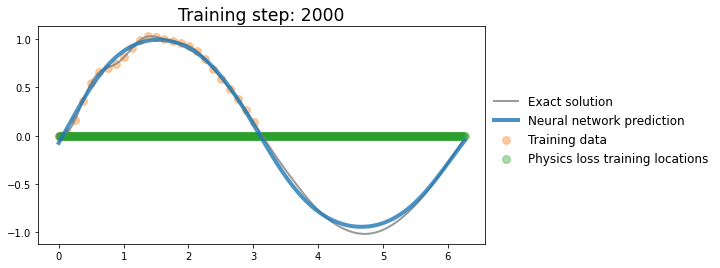

iteration: 3000
iteration: 4000


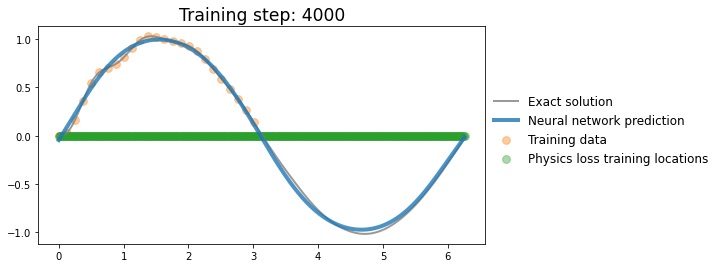

iteration: 5000
iteration: 6000


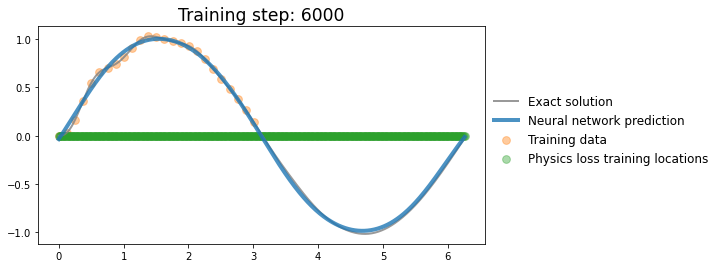

iteration: 7000
iteration: 8000


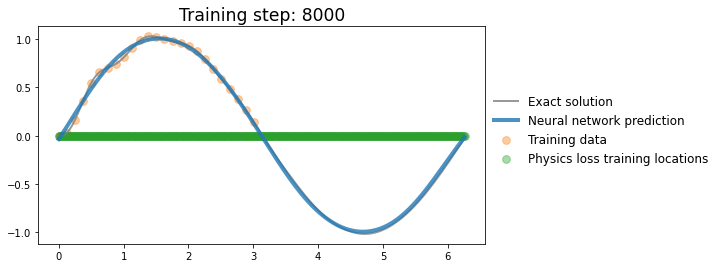

iteration: 9000
iteration: 10000


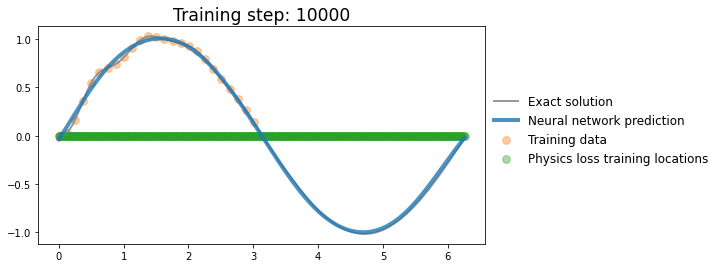

iteration: 11000
iteration: 12000


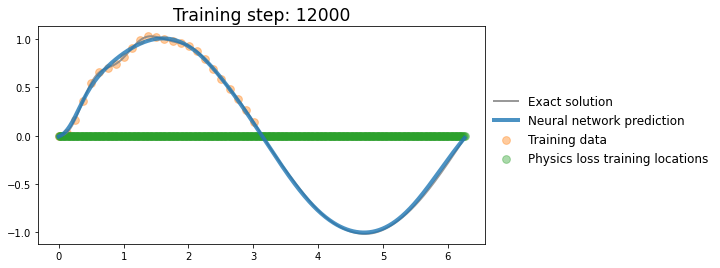

iteration: 13000
iteration: 14000


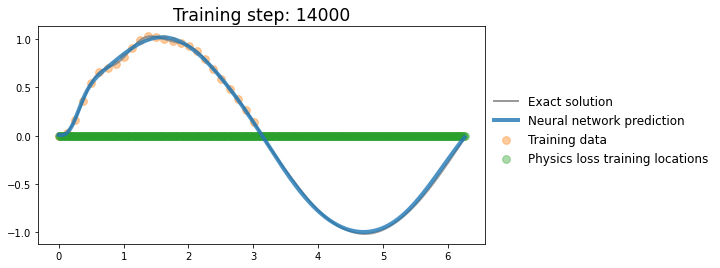

iteration: 15000
iteration: 16000


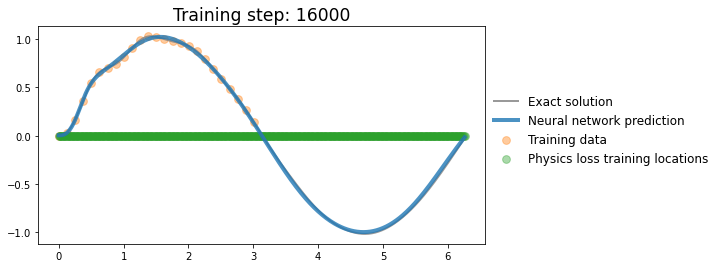

iteration: 17000
iteration: 18000


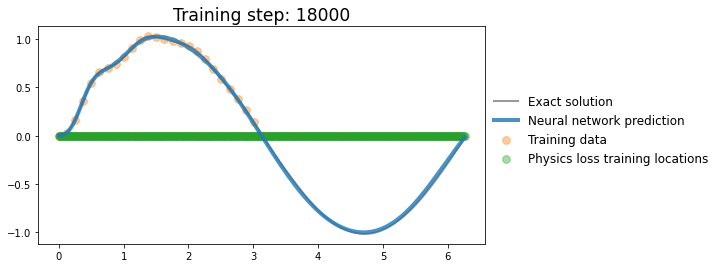

iteration: 19000
iteration: 20000


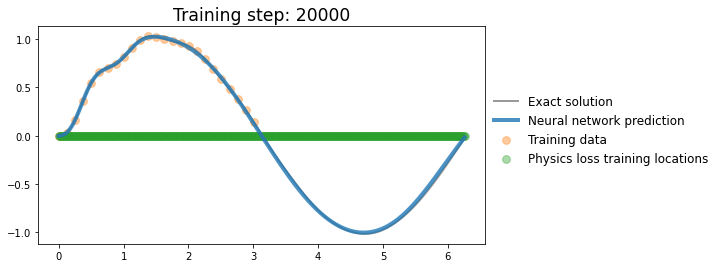

iteration: 21000
iteration: 22000


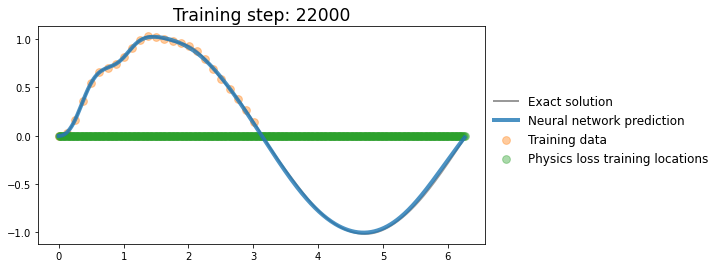

iteration: 23000
iteration: 24000


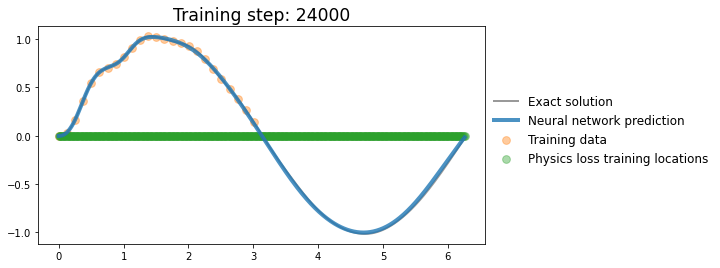

iteration: 25000
iteration: 26000


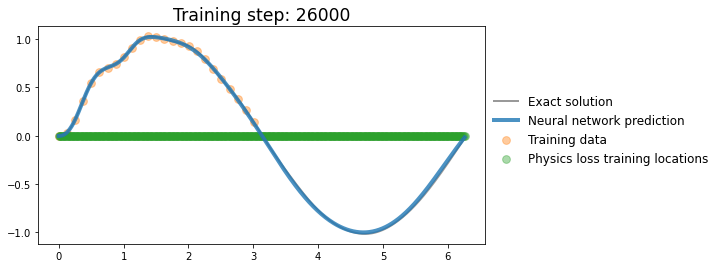

iteration: 27000
iteration: 28000


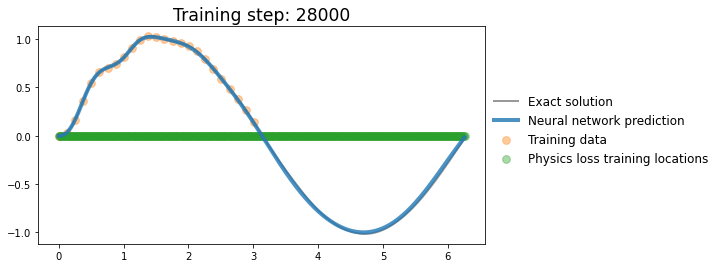

iteration: 29000
iteration: 30000


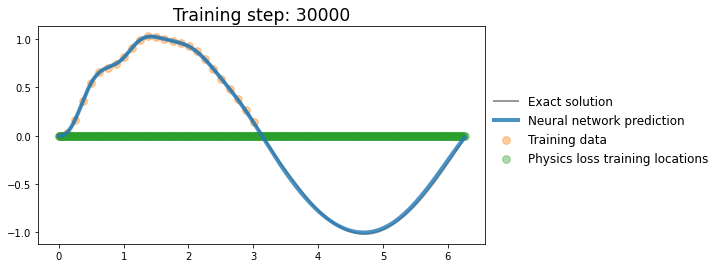

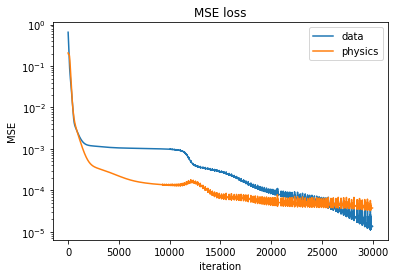

In [179]:
iterations = 30000

scale_factor_p_loss = [1e-4]
train_point_step_size = [10] # smaller number = more training points! todo change
end_t_points = 250 # until what time step training points should be taken, 250= tp from first half, 500=tp sampled from whole domain
show_plots = {"prediction": 1, "p_vs_p_hand": 0, "p_term": 0, "p_dx": 0, "p_dx2": 0}
plot_frequency = 2000 # show plots aftern n iterations

for lb in scale_factor_p_loss:
  print("Scaling factor physiscs loss: " + str(lb))
  total_score_lst = []
  loss_lst = []
  #loss_terms_lst = [] #treks all p loss terms indiviually
  loss_terms_p_lst_comp = [] # contains mse between terms of hand solution physiscs loss (e.g. )

  for step_s in train_point_step_size:
    torch.manual_seed(123)
    
    t_data, x_data, u_data, u_pkt_data, t_physics, u_physics, u_pkt_physics = set_data(step_s, end=end_t_points)

    u_physics = torch.tensor(u_orig[0:len(t):1]).float().clone().detach().requires_grad_(True)
    u_pkt_physics = torch.tensor(up_orig[0:len(t):1]).float().clone().detach().requires_grad_(True)


######
    model = FCN(2,1,32,3) # N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
    #optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)

    files = []

    diff_all_lst = []
    #loss_adapt_lst = []
    #loss_adapt_lst.append([0, 0])
    for i in range(iterations):
        optimizer.zero_grad()
        
        # compute the "data loss"
        x_out = model(t_data, u_data)
        loss_data = torch.mean((x_out-x_data)**2)
        
        # compute the "physics loss"
        x_out_physics = model(t_physics, u_physics)
        dx  = torch.autograd.grad(x_out_physics, t_physics, torch.ones_like(x_out_physics), create_graph=True)[0]# computes dx/dt
        dx2 = torch.autograd.grad(dx,  t_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2x/dt^2

        # uncomment to use hand solution for dx2 or dx testing only
        #dx2= torch.from_numpy(np.expand_dims(dx2_hand[:500],1))
        #dx = torch.from_numpy(np.expand_dims(dx_hand[:500],1))

        physics = -dx2 - d*dx - c*x_out_physics + d*u_pkt_physics + c*u_physics
        # scale loss
        loss_physics = lb*torch.mean(physics**2)

        #loss_terms_lst.append([torch.mean(-dx2 - d*dx - c*x_out_physics), torch.mean(d*u_pkt_physics + c*u_physics), torch.mean(dx2), torch.mean(d*dx), torch.mean(c*yhp), torch.mean(d*u_pkt_physics), torch.mean(c*u_physics)])
        #loss_adapt_lst.append([loss_data.item(), loss_physics.item()])
        
        # backpropagate joint loss
        loss = loss_data + loss_physics

        loss_lst.append([loss.item(), loss_data.item(), loss_physics.item()])
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1000 == 0:
          print("iteration: " + str(i+1))
        # plot the result as training progresses
        if (i+1) % plot_frequency == 0: 
            
            x_out = model(t, u).detach()
            xp = t_physics.detach()

            score_raw =  ((x_out-x)**2)
            diff_all_lst.append([torch.mean(score_raw).item(), torch.mean(score_raw[:250]).item(), torch.mean(score_raw[250::]).item(),i])
           
            
            
            loss_terms_p_lst_comp.append([torch.mean((x_out.detach()-y[:500])**2), 
                                      torch.mean((dx.detach()-dx_hand[:500])**2),
                                      torch.mean((dx2.detach()-dx2_hand[:500])**2)])
            
            if show_plots.get("prediction"):
              plot_result(t,x,t_data,x_data,x_out,xp)
              plt.show()
            if show_plots.get("p_vs_p_hand"):
              plt.figure()
              plt.title("physiscs term vs physiscs term by hand iteration:" + str(i+1))
              plt.plot(t, physics.detach(), label="physiscs",linewidth=4,)
              plt.plot(t, res_hand[:500], label="physiscs_hand")
              plt.xlabel("t")
              plt.legend()
              plt.show()
            if show_plots["p_term"]:
              plt.figure()
              plt.title("")
              plt.title("physiscs loss iteration: " + str(i+1))
              plt.plot(t, physics.detach(), label="physiscs",linewidth=4,)
              plt.xlabel("t")
              plt.legend()
              plt.show()
            if show_plots["p_dx"]:
              plt.figure()
              plt.title("dx vs dx_hand iteration: " + str(i+1))
              plt.plot(t, dx.detach(), label="dx",linewidth=4,)
              plt.plot(t, dx_hand[:500], label="dx_hand")
              plt.xlabel("t")
              plt.legend()
              plt.show()
            if show_plots["p_dx2"]:
              plt.figure()
              plt.title("dx2 vs dx2_hand iteration: " + str(i+1))
              plt.plot(t, dx2.detach(), label="dx2",linewidth=4)
              plt.plot(t, dx2_hand[:500], label="dx2_hand")
              plt.xlabel("t")
              plt.legend()
              plt.show()

        else:
          plt.close("all")
    total_score_lst.append(
            [np.min([lst[0] for lst in diff_all_lst]),
            np.min([lst[1] for lst in diff_all_lst]),
            np.min([lst[2] for lst in diff_all_lst]),
            [lst[3] for lst in diff_all_lst][np.argmin([lst[0] for lst in diff_all_lst])],
            [lst[3] for lst in diff_all_lst][np.argmin([lst[1] for lst in diff_all_lst])], 
              [lst[3] for lst in diff_all_lst][np.argmin([lst[2] for lst in diff_all_lst])]])

  fig = plt.figure()
  plt.plot([l[1] for l in loss_lst], label="data")
  plt.plot([l[2] for l in loss_lst], label = "physics")
  plt.title("MSE loss")
  plt.yscale("log")
  plt.ylabel("MSE")
  plt.xlabel("iteration")
  plt.legend()
  plt.show()
  
  #plt.show()
  #with open(data_path_small + "comp_neu/pinn_score_diff_tp_half_detail.pkl", "wb") as fp:   #Pickling
  #      pickle.dump(diff_all_lst, fp)
  #with open(data_path_small + "comp_neu/pinn_score_diff_tp_half.pkl", "wb") as fp:   #Pickling
  #      pickle.dump(total_score_lst, fp)

# Normal Neural Network

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


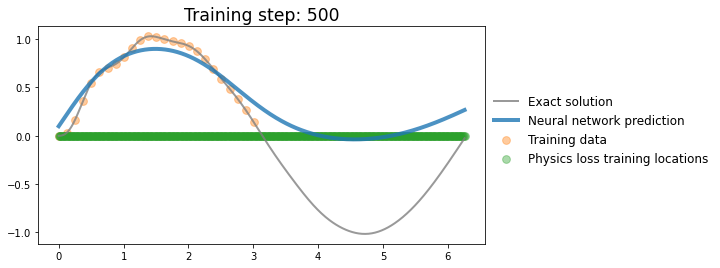

iteration: 1000


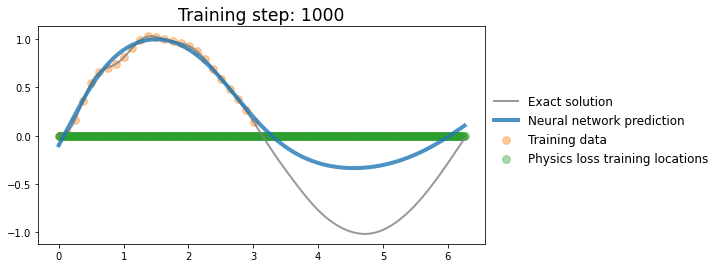

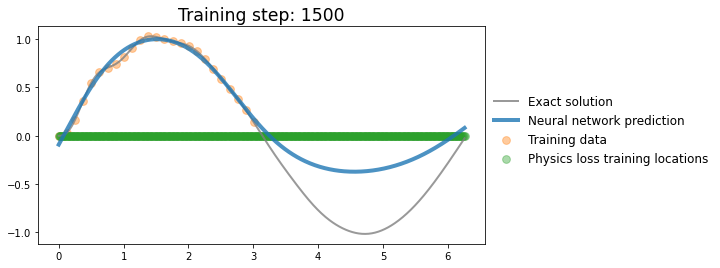

iteration: 2000


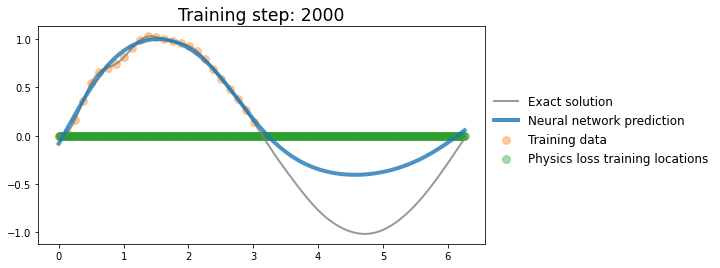

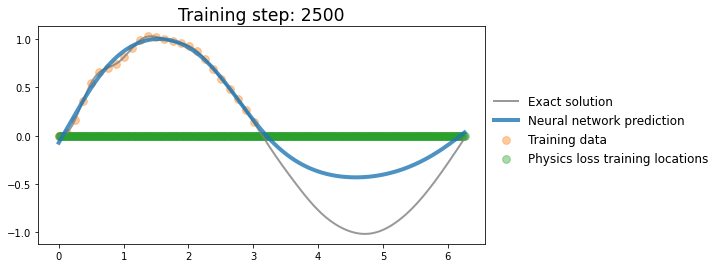

iteration: 3000


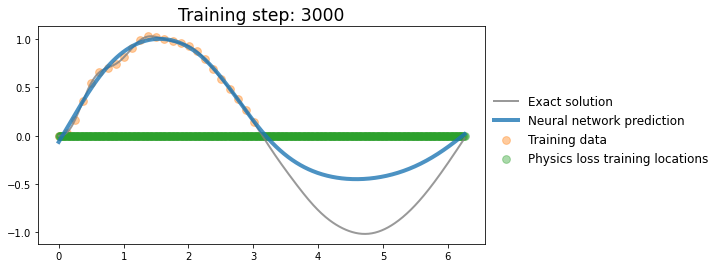

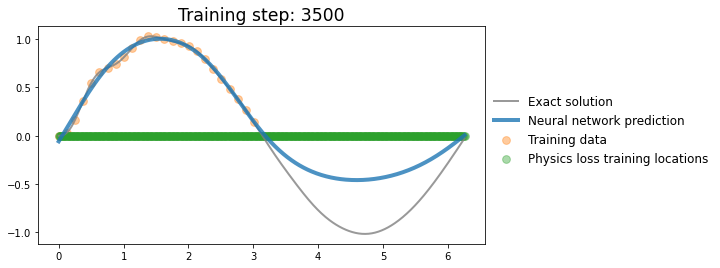

iteration: 4000


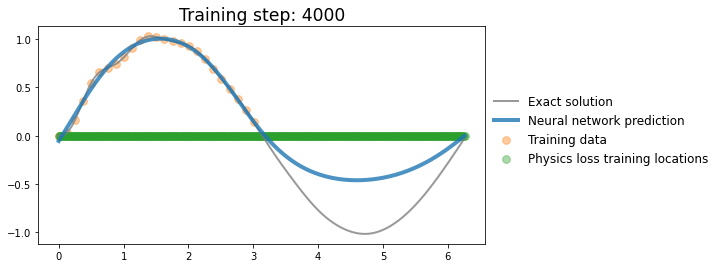

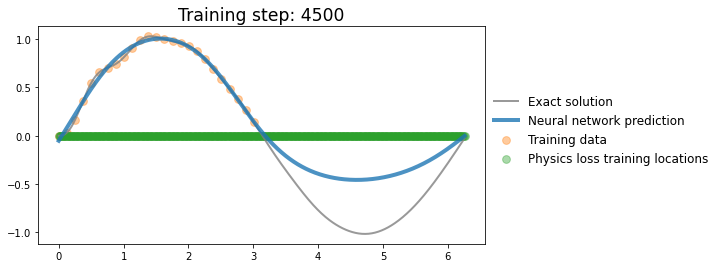

iteration: 5000


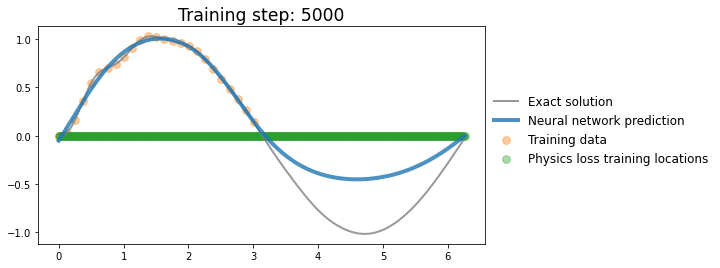

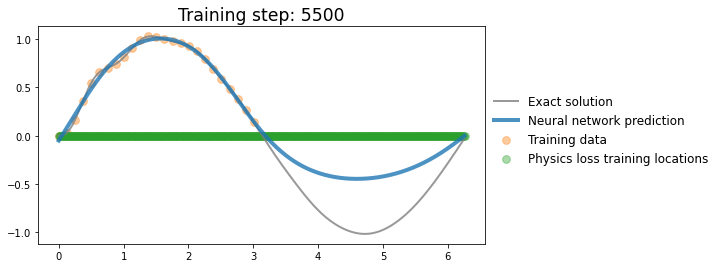

iteration: 6000


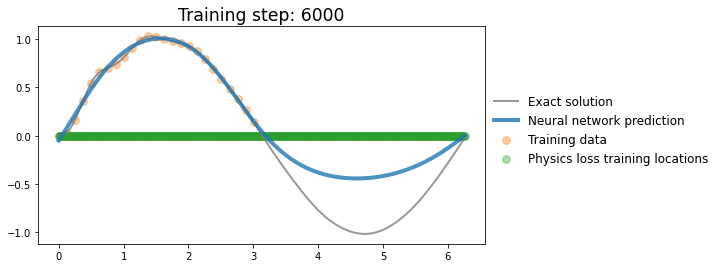

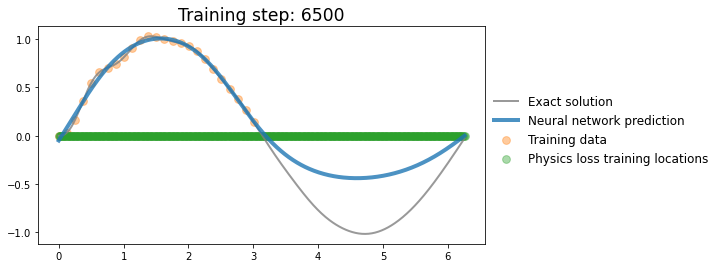

iteration: 7000


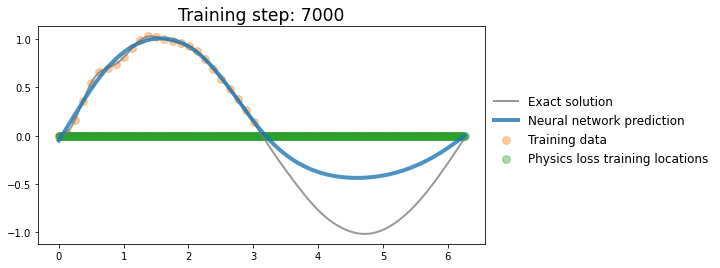

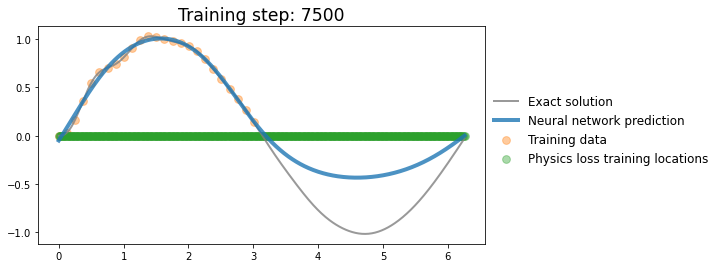

iteration: 8000


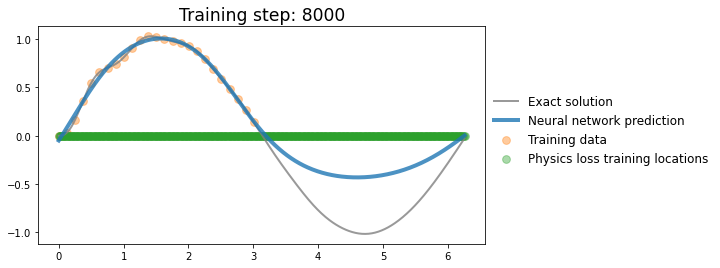

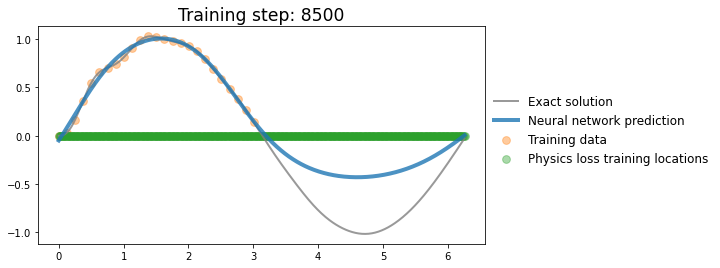

iteration: 9000


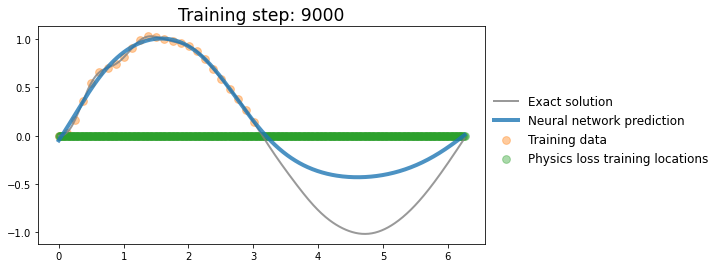

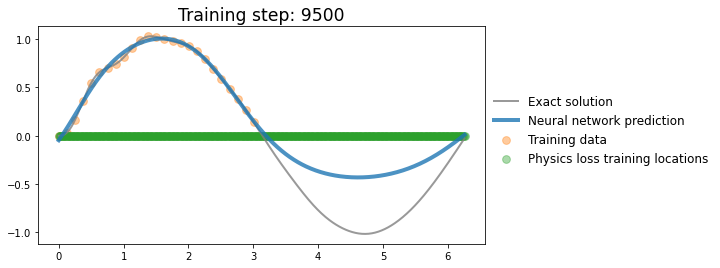

iteration: 10000


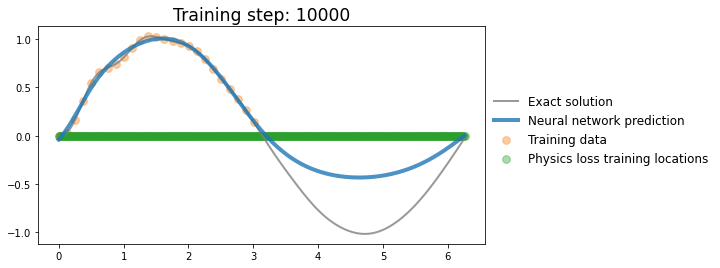

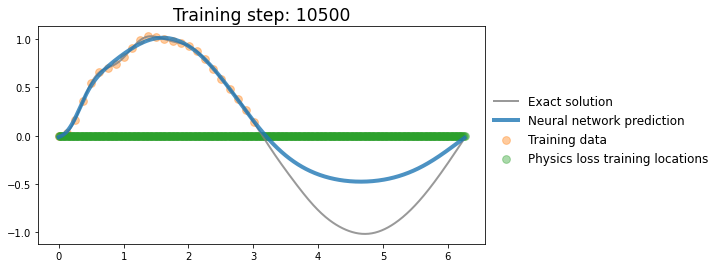

iteration: 11000


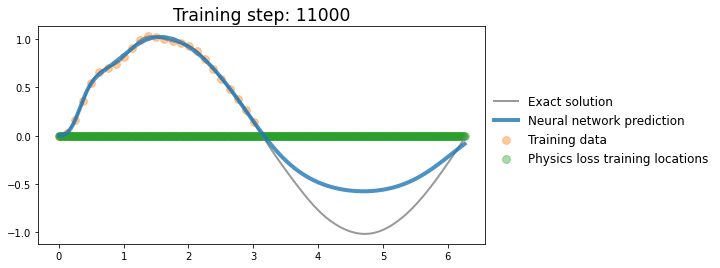

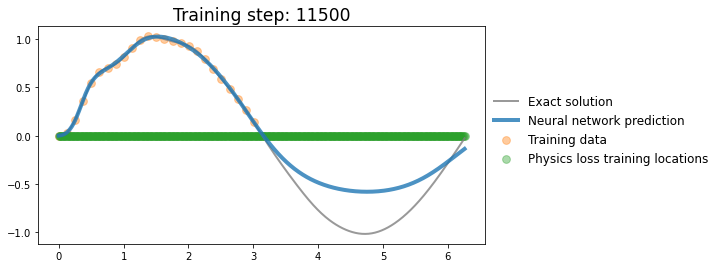

iteration: 12000


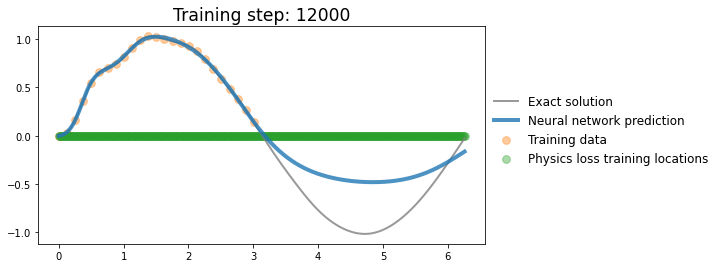

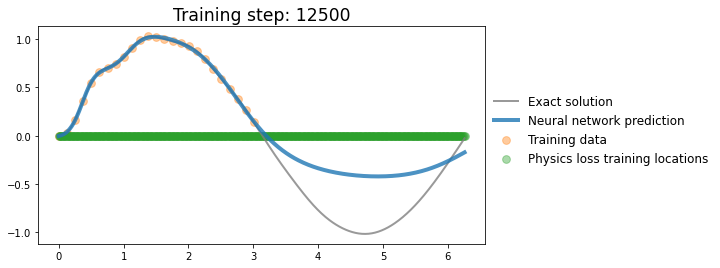

iteration: 13000


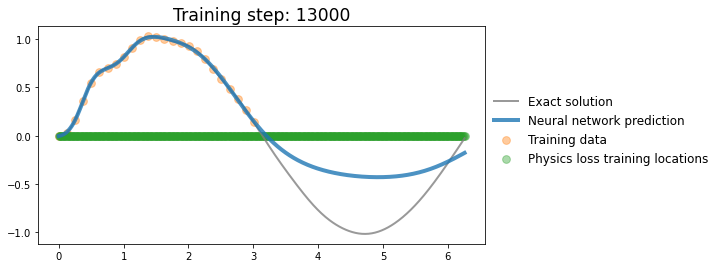

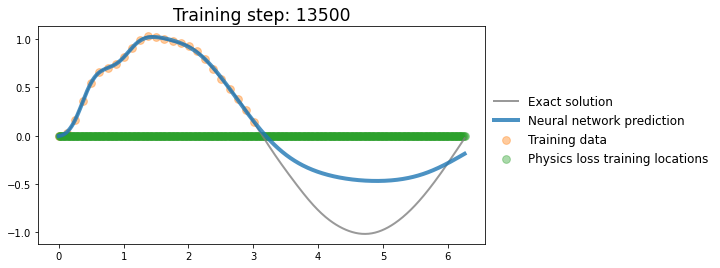

iteration: 14000


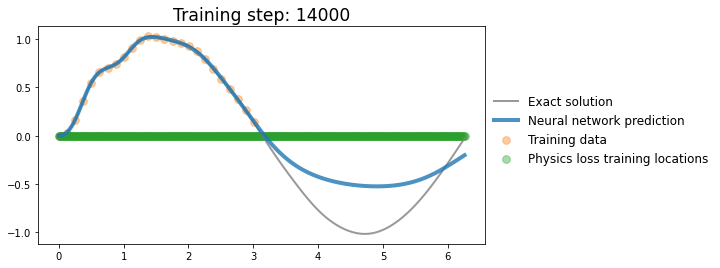

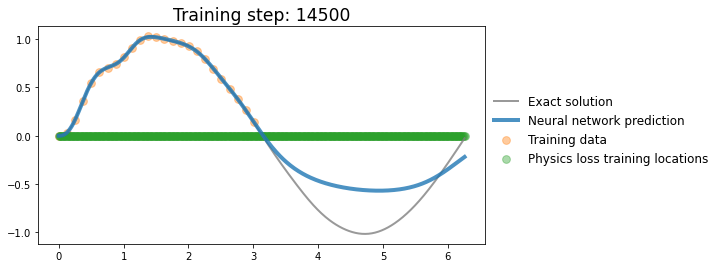

iteration: 15000


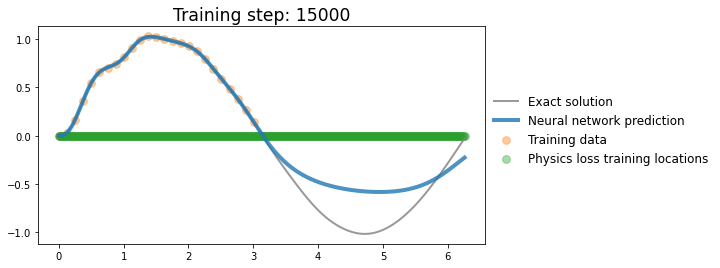

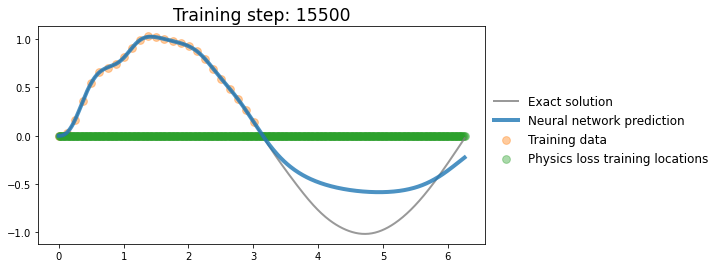

iteration: 16000


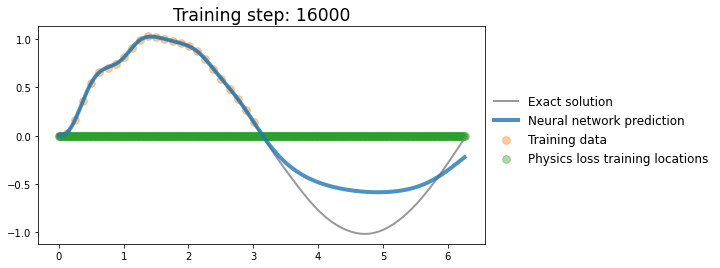

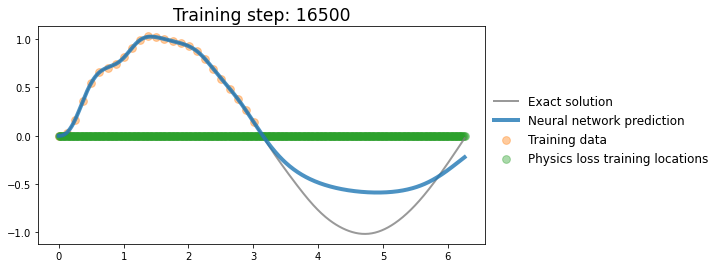

iteration: 17000


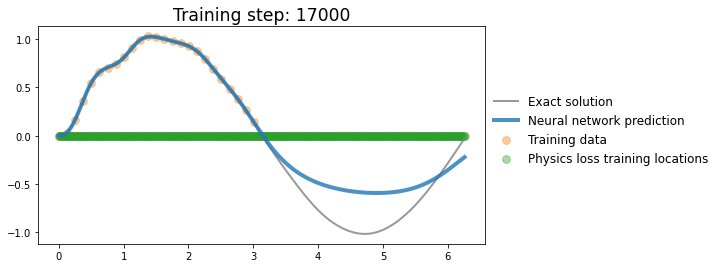

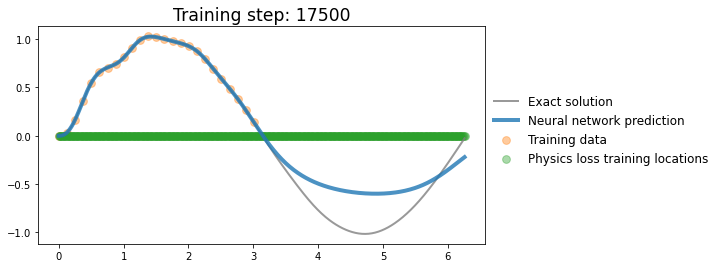

iteration: 18000


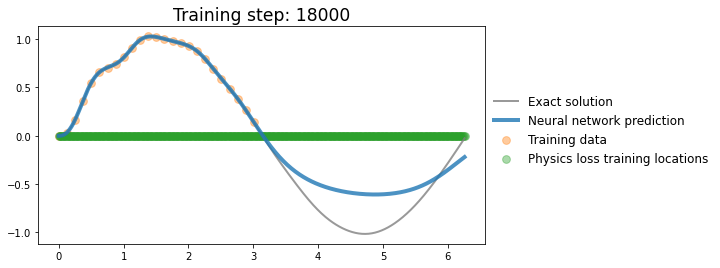

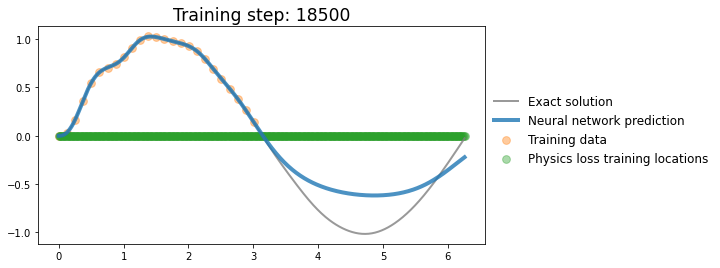

iteration: 19000


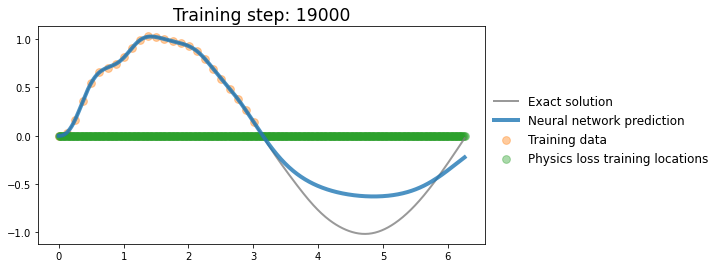

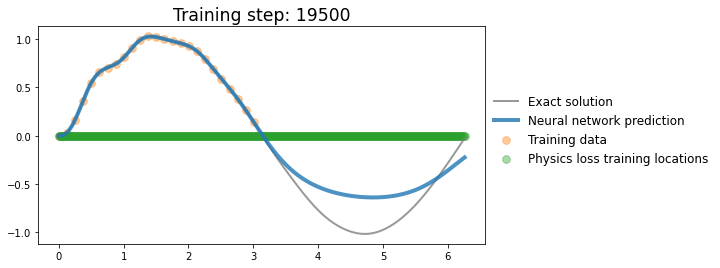

iteration: 20000


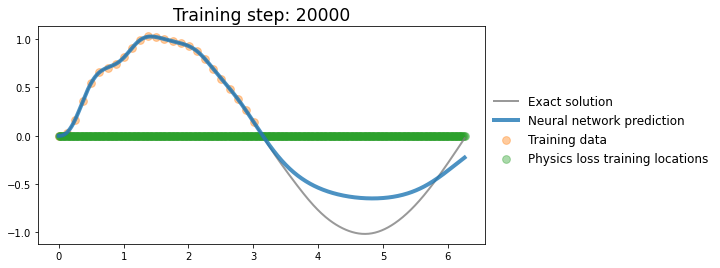

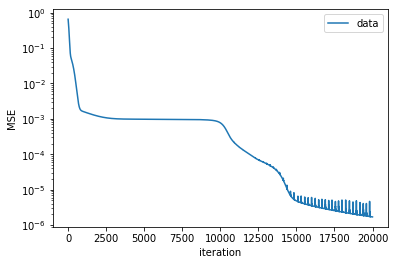

In [157]:
yhp_nn = 0
dx_nn  = 0
dx2_nn = 0

# train standard neural network to fit training data
#train_lst_steps = [250, 125, 50, 25 , 10, 5,2]
train_lst_steps = [10]
#train_lst_steps = [500, 250, 100, 50 , 20, 10,4]
total_score_lst = []
iterations = 20000
for step_s in train_lst_steps:
  torch.manual_seed(123)
  t_data, x_data, u_data, u_pkt_data, t_physics, u_physics, u_pkt_physics = set_data(step_s)

  model = FCN(2,1,32,3) # N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
  files = []

  diff_all_lst = []
  l_lst = []
  for i in range(iterations):
      optimizer.zero_grad()
      
      # compute the "data loss"
      x_out = model(t_data, u_data)
      loss1 = torch.mean((x_out-x_data)**2)# use mean squared error
      l_lst.append(loss1.item())
      loss = loss1
      loss.backward()
      optimizer.step()
      
      if (i+1) % 1000 == 0:
        print("iteration: " + str(i+1))
      # plot the result as training progresses
      if (i+1) % 250000 == 0:
        # compute the "physics loss"
        yhp_nn = model(t_physics, u_physics)
        dx_nn  = torch.autograd.grad(yhp_nn, t_physics, torch.ones_like(yhp_nn), create_graph=True)[0]# computes dy/dx
        dx2_nn = torch.autograd.grad(dx_nn,  t_physics, torch.ones_like(dx_nn),  create_graph=True)[0]# computes d^2y/dx^2


      if (i+1) % 500 == 0: 
          
          yh = model(t, u).detach()
          #yh = model(x).detach()
          xp = t_physics.detach()
          score_raw =  ((yh-x)**2)
          diff_all_lst.append([torch.mean(score_raw).item(), torch.mean(score_raw[:250]).item(), torch.mean(score_raw[250::]).item(),i])
          plot_result(t,x,t_data,x_data,yh,xp)
          
          file = "plots/pinn_%.8i.png"%(i+1)
          plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
          files.append(file)
          
          if (i+1) % 250 == 0 and True: plt.show()
          else: plt.close("all")
  total_score_lst.append(
          [np.min([lst[0] for lst in diff_all_lst]),
          np.min([lst[1] for lst in diff_all_lst]),
          np.min([lst[2] for lst in diff_all_lst]),
          [lst[3] for lst in diff_all_lst][np.argmin([lst[0] for lst in diff_all_lst])],
          [lst[3] for lst in diff_all_lst][np.argmin([lst[1] for lst in diff_all_lst])], 
            [lst[3] for lst in diff_all_lst][np.argmin([lst[2] for lst in diff_all_lst])]])
  

  #plt.show()

#with open(data_path_small + "comp_neu/nn_score_diff_tp_half_detail.pkl", "wb") as fp:   #Pickling
#      pickle.dump(diff_all_lst, fp)
#with open(data_path_small + "comp_neu/nn_score_diff_tp_whole.pkl", "wb") as fp:   #Pickling
#      pickle.dump(total_score_lst, fp)
fig = plt.figure()
plt.plot(l_lst, label="data")
plt.yscale("log")
plt.ylabel("MSE")
plt.xlabel("iteration")
plt.legend()